In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")

import os
import argparse
import numpy as np
import matplotlib.pyplot as plt

from Potential import Potential
from Channel import Channel
from Scattering import Scattering
from ScatteringExp import ScatteringExp
from Grid import Grid
import RseSolver
from scipy.special import factorial2, spherical_jn
from plots.rc_params import *

In [2]:
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
l = 2
channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
potential = Potential(channel, **potentialArgs)
E_MeV = 50
scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)
rmatch = 12
grid = Grid(1e-24, rmatch, numIntervals=1, numPointsPerInterval=1200,
            type="linear", test=False)  # needs equidistant grids as of now
trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

from NumerovEmulator import AffineGROM
# Test config for no greedy
emulator_pod = AffineGROM(scattExp=scattExp, 
                          grid=grid, 
                          free_lecs={"V0": (0, 400)},
                          num_snapshots_init=80, 
                          num_snapshots_max=100,
                          approach="pod", 
                          pod_rcond=1e-12, 
                          init_snapshot_lecs=None,
                          greedy_max_iter=5, 
                          mode="linear"
                          )

using 6 out of 80 POD modes in total: compression rate is 92.5 %


In [233]:
from RseSolver import RseSolver
inhomogeneous=True
args = dict(asympParam="K", matching=True)
solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=inhomogeneous)
num1  = solver.solve(lecList=testingLecList, method="Numerov_affine", **args)
num2  = solver.solve(lecList=testingLecList, method="Numerov", **args)
numk  = solver.solve(lecList=testingLecList, method="RK45", **args)
print("diff", np.max(np.abs(num1[0].u-num2[0].u)))
print("diff", np.max(np.abs(numk[0].u-num2[0].u)))
print(num1[0].Lmatrix.value)

testing
4.440892098500626e-16
diff 1.1757261830780408e-13
diff 7.262973555910435e-11
0.12807611086628629


In [3]:
rseParams = {"grid": grid, "scattExp": scattExp, "potential": scattExp.potential, 
             "inhomogeneous": True, 
             "asympParam": "K", "method": "lsqfit", 
             "matching": False,
             "lecs": testingLecList[0]
             }

In [235]:
from Numerov import numerov2
from RseSolver import g, s
_, _, _, sol = numerov2(grid.points, y0=0, g=g, s=s, solve=True, params=rseParams)
# plt.plot(grid.points, sol[:-1])
# plt.ylim(-2,2)
print("Kmat", sol[-1])
print(sol[-3:-1])

Kmat 0.1280761109275306
[-0.08706635 -0.0860288 ]


In [8]:
np.set_printoptions(edgeitems=10, linewidth=400)
from Numerov import EverythingAllAtOnceNumerov
from RseSolver import g_s, g_s_affine
aa = EverythingAllAtOnceNumerov(xn=grid.points, g=None, 
                                g_s=g_s_affine, params=rseParams)
lecs = np.array([1,200,-91.85])
print(aa.S_tensor.shape)
abar = np.tensordot(lecs, aa.Abar_tensor, axes=1)
ss = np.tensordot(lecs, aa.S_tensor, axes=1)
abar
sys = np.tensordot(lecs, aa.A_tensor, axes=1)
sol_new = np.linalg.solve(sys, ss)

(3, 1200)


In [237]:
np.max(np.abs(sol_new[:-1] - num1[0].chi[1:]))

5.98317229094647e-11

In [254]:
count = 0
for elem in sol_new:
    if np.isfinite(elem):
        count += 1
print(count, len(sol_new))

1200 1200


/Users/cdrischler/GitHub/greedy_emulator/env/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/cdrischler/GitHub/greedy_emulator/env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.12807611092753096

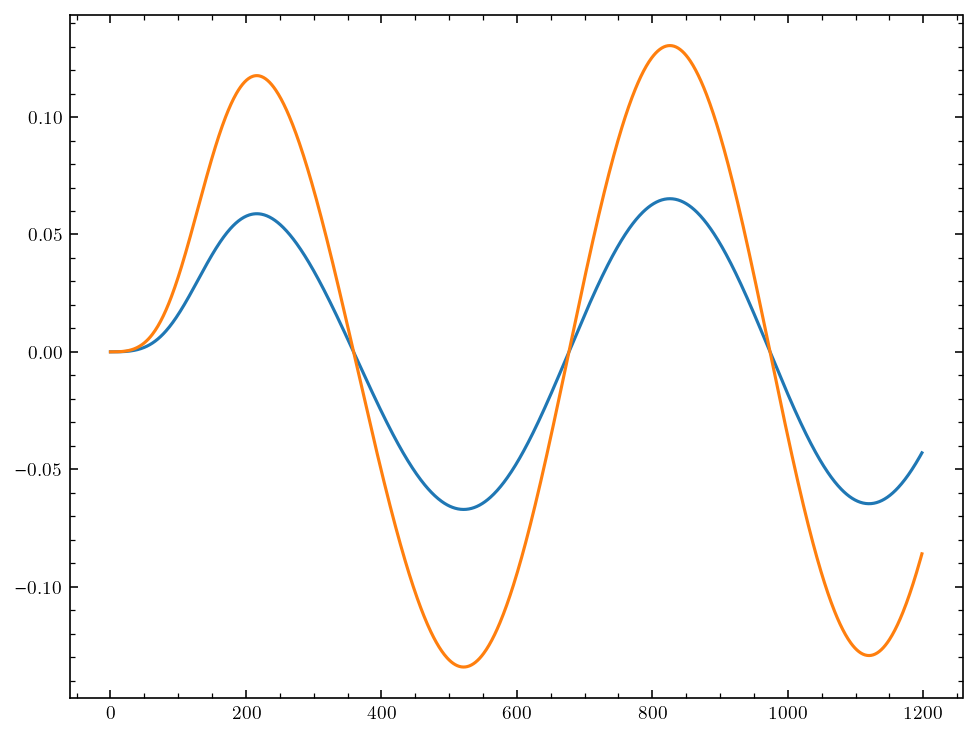

In [ ]:
plt.plot(sol_new[:-1])
plt.plot(numk[0].chi[1:])
sol_new[-1] #-2*0.30244898813852295

In [191]:
from Numerov import diag_ord_form_to_mat
np.max(np.abs(np.tensordot(lecs, aa.A_tensor, axes=1) - diag_ord_form_to_mat(ab, (1,1), toarray=True)))

ValueError: operands could not be broadcast together with shapes (600,600) (1200,1200) 

In [33]:
import scipy as sp
np.max(np.abs(sol - np.concatenate(([0],sp.linalg.solve_banded((1,1), ab=abar, b=ss)))))

2.7755575615628914e-15

In [51]:
np.max(np.abs(abar - ab))

4.440892098500626e-16

In [138]:
np.max(np.abs(np.linalg.solve(sys, ss) - sol[1:]))

6.291744902853225e-12

In [23]:
np.max(np.abs(ab-abar))

5.551115123125783e-16

Kmat 0.1280761109275306
[-0.08706635 -0.0860288 ]


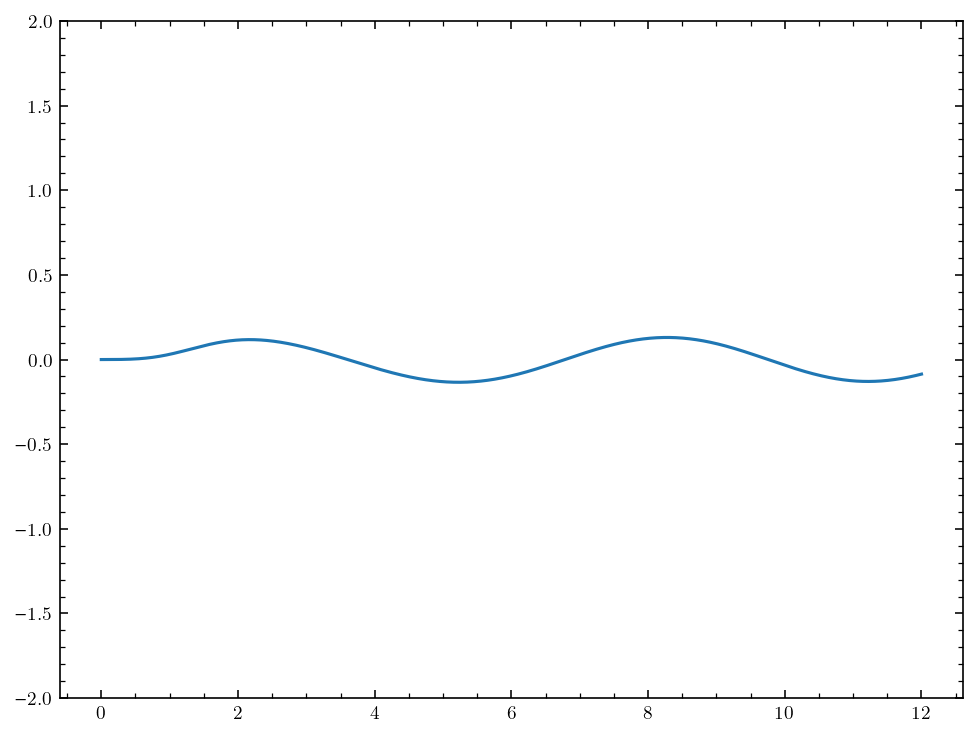

In [241]:
from Numerov import numerov2
from RseSolver import g, s
absp, ab, s, sol = numerov2(grid.points, y0=0, g=g, s=s, solve=True, params=rseParams)
plt.plot(grid.points, sol[:-1])
plt.ylim(-2,2)
print("Kmat", sol[-1])
print(sol[-3:-1])

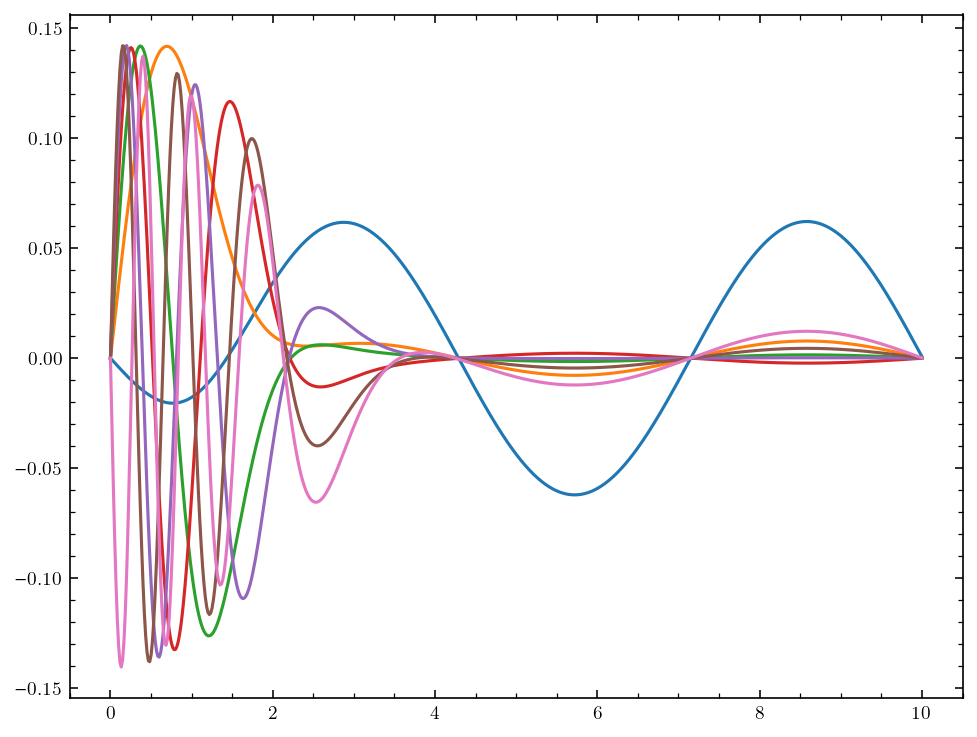

In [185]:
plt.plot(emulator_pod.grid.points, emulator_pod.snapshot_matrix)
# for line in np.arange(0,5,2) * np.pi/2:
    # plt.axvline(line)

In [186]:
emulator_pod.snapshot_matrix

array([[-7.90348363e-16, -5.64756977e-17, -1.32624990e-14, ...,
        -1.56450719e-10, -2.81064521e-08,  6.96212340e-06],
       [-6.76500397e-04,  5.53254186e-03,  1.01747709e-02, ...,
         1.92123481e-02,  2.37291535e-02, -2.77768238e-02],
       [-1.35233318e-03,  1.10560860e-02,  2.02959416e-02, ...,
         3.80695978e-02,  4.67902952e-02, -5.44494709e-02],
       ...,
       [ 2.98981443e-03,  3.75770293e-04,  7.30255126e-05, ...,
         8.55398566e-06,  2.15828667e-04,  5.88893712e-04],
       [ 1.85181953e-03,  2.32743129e-04,  4.52302537e-05, ...,
         5.29813339e-06,  1.33678660e-04,  3.65086282e-04],
       [ 7.13201953e-04,  8.96377042e-05,  1.74197861e-05, ...,
         2.04050117e-06,  5.14834560e-05,  1.41375482e-04]])

In [187]:
print(emulator_pod.snapshot_Lvec.shape)
emulator_pod.Lmatrix(np.ones(7))

(7,)


-0.08606388580146387

In [192]:
[elem.Lmatrix.value for elem in emulator_pod.snapshot_matrix2]

[1.7892471497074987,
 1.6987177548176522,
 1.614932468440648,
 1.5371342217896067,
 1.4646753517903086,
 1.3969985240801437,
 1.3336215132813174,
 1.2741249603035758,
 1.2181424487547734,
 1.165352403621352,
 1.115471433415937,
 1.0682488243921677,
 1.0234619607583646,
 0.9809124941570403,
 0.9404231231823899,
 0.9018348725310875,
 0.865004783622441,
 0.8298039458828939,
 0.7961158114672985,
 0.7638347469293145,
 0.7328647838590323,
 0.7031185373147608,
 0.6745162663318218,
 0.6469850551996709,
 0.6204580977770938,
 0.5948740700251868,
 0.570176578327663,
 0.5463136731297776,
 0.5232374190470954,
 0.5009035139392716,
 0.47927095056484714,
 0.4583017153633796,
 0.4379605196975707,
 0.41821455954759507,
 0.39903330020175065,
 0.38038828296379124,
 0.3622529512928067,
 0.34460249413452865,
 0.32741370449254753,
 0.3106648515375381,
 0.29433556476579786,
 0.2784067289040195,
 0.26286038841315496,
 0.24767966058582389,
 0.23284865634637078,
 0.21835240796981822,
 0.2041768030236896,
 0.1903

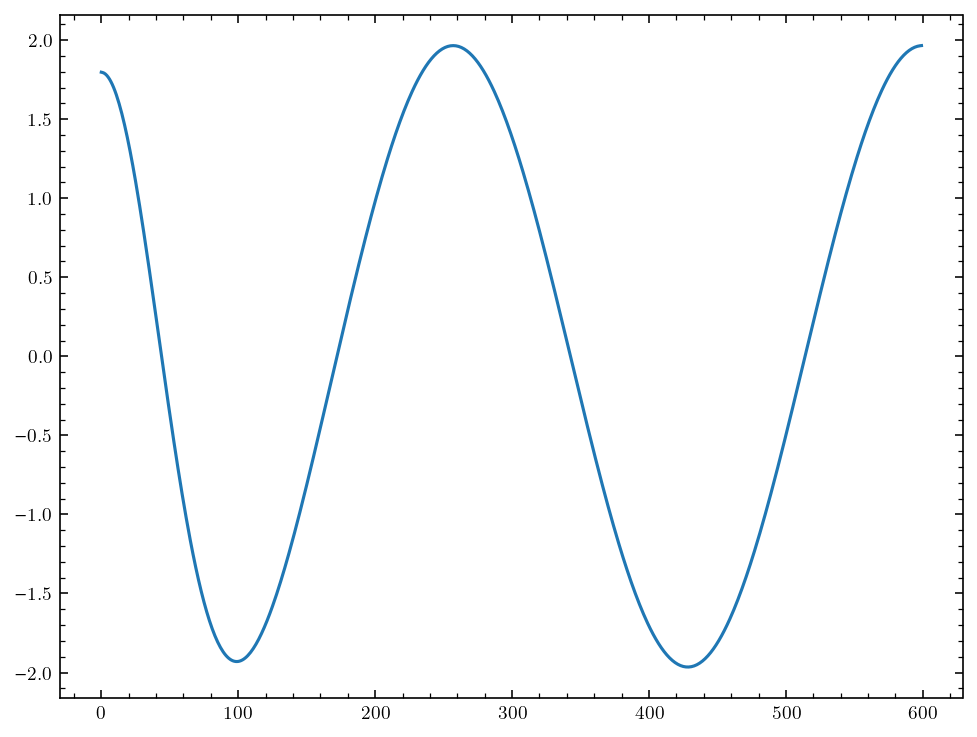

In [188]:
plt.plot(emulator_pod.snapshot_matrix2[0].chiprime)

In [157]:
np.diag([1,2,3])

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

# New emulator

In [4]:
from NumerovEmulator import AffineGROM

In [112]:
grom = AffineGROM(scattExp=scattExp,
           grid=grid, 
           free_lecs={"V0": (0, 400)}, 
           num_snapshots_init=200, 
            num_snapshots_max=50000, 
            approach="pod", 
            pod_rcond=1e-10, 
            init_snapshot_lecs=None,
            greedy_max_iter=5, 
            mode="linear",
            seed=10203
            )

using 5 out of 200 POD modes in total: compression rate is 97.5 %
POD[ Y ]: compression rate is 22.2 %; dim: (1200, 14)


In [68]:
import scipy as sp
arr = np.array([[1,1,1], [1,1,0], [1,1,1]]).T
print(arr)
q, r = sp.linalg.qr(arr, mode='economic')
q

[[1 1 1]
 [1 1 1]
 [1 0 1]]


array([[-5.77350269e-01, -4.08248290e-01, -7.07106781e-01],
       [-5.77350269e-01, -4.08248290e-01,  7.07106781e-01],
       [-5.77350269e-01,  8.16496581e-01,  5.55111512e-17]])

In [76]:
arr = np.array([[1,1,1], [1,1,0]]).T
q, r = sp.linalg.qr(arr, mode='economic')
q2, r2 = sp.linalg.qr_insert(q, r, k=-1, u=np.array([1.,1,1]), which="col", rcond=None)

try:
    q2, r2 = sp.linalg.qr_insert(q, r, k=-1, u=np.array([1.,1,1]), which="col", rcond=None)
except sp.linalg.LinAlgError:
    arr = np.array([[1,1,1], [1,1,0], [1,1,1]]).T
    q, r = sp.linalg.qr(arr, mode='economic')
q

LinAlgError: One of the columns of u lies in the span of Q. Found reciprocal condition number of 1.359739955510518e-16 for Q augmented with u/||u||.

In [42]:
xsol, xres, _, _ = np.linalg.lstsq(q.T @ r, [0.5,0.5], rcond=None)
xres

array([], dtype=float64)

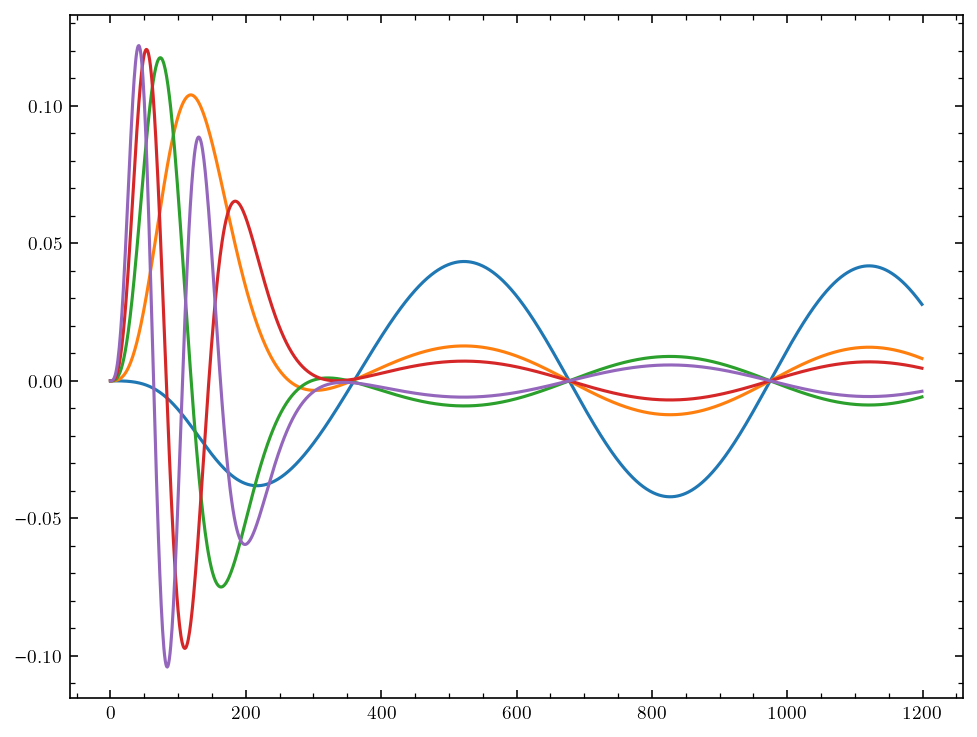

In [6]:
plt.plot(grom.snapshot_matrix[:-1])

In [9]:
grom.simulate([lecs])[-1]

array([0.12807611])

In [10]:
grom.lec_all_samples

array([[  1.        ,   0.        , -91.85      ],
       [  1.        ,   2.01005025, -91.85      ],
       [  1.        ,   4.0201005 , -91.85      ],
       [  1.        ,   6.03015075, -91.85      ],
       [  1.        ,   8.04020101, -91.85      ],
       [  1.        ,  10.05025126, -91.85      ],
       [  1.        ,  12.06030151, -91.85      ],
       [  1.        ,  14.07035176, -91.85      ],
       [  1.        ,  16.08040201, -91.85      ],
       [  1.        ,  18.09045226, -91.85      ],
       [  1.        ,  20.10050251, -91.85      ],
       [  1.        ,  22.11055276, -91.85      ],
       [  1.        ,  24.12060302, -91.85      ],
       [  1.        ,  26.13065327, -91.85      ],
       [  1.        ,  28.14070352, -91.85      ],
       [  1.        ,  30.15075377, -91.85      ],
       [  1.        ,  32.16080402, -91.85      ],
       [  1.        ,  34.17085427, -91.85      ],
       [  1.        ,  36.18090452, -91.85      ],
       [  1.        ,  38.19095

In [11]:
lecs

array([  1.  , 200.  , -91.85])

In [34]:
grom.fom_solutions[1,:]

array([ 7.79208865e-08,  7.72548465e-08,  7.65920896e-08,  7.59325957e-08,  7.52763451e-08,  7.46233182e-08,  7.39734954e-08,  7.33268575e-08,  7.26833853e-08,  7.20430596e-08,  7.14058615e-08,  7.07717723e-08,  7.01407733e-08,  6.95128460e-08,  6.88879720e-08,  6.82661331e-08,  6.76473112e-08,  6.70314882e-08,  6.64186464e-08,  6.58087680e-08,  6.52018355e-08,  6.45978313e-08,  6.39967382e-08,
        6.33985388e-08,  6.28032162e-08,  6.22107534e-08,  6.16211335e-08,  6.10343397e-08,  6.04503556e-08,  5.98691646e-08,  5.92907503e-08,  5.87150965e-08,  5.81421870e-08,  5.75720059e-08,  5.70045372e-08,  5.64397651e-08,  5.58776739e-08,  5.53182482e-08,  5.47614723e-08,  5.42073309e-08,  5.36558089e-08,  5.31068910e-08,  5.25605623e-08,  5.20168078e-08,  5.14756126e-08,  5.09369621e-08,
        5.04008416e-08,  4.98672367e-08,  4.93361329e-08,  4.88075158e-08,  4.82813714e-08,  4.77576854e-08,  4.72364438e-08,  4.67176328e-08,  4.62012384e-08,  4.56872470e-08,  4.51756450e-08,  4.4666418

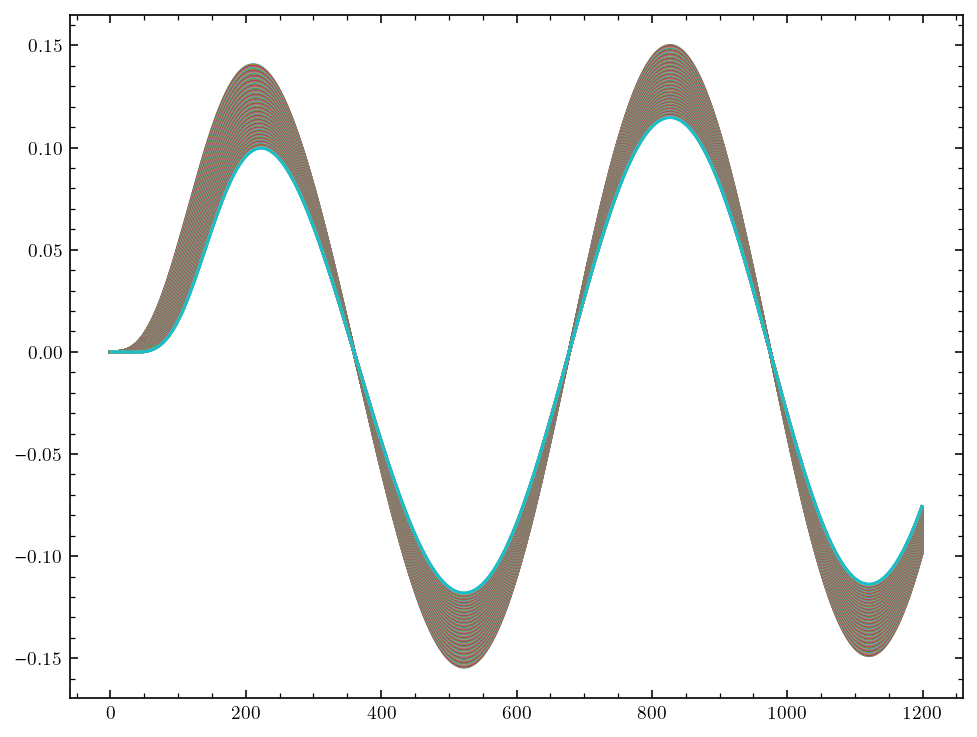

In [17]:
plt.plot(grom.fom_solutions[:-1,:])

In [25]:
%timeit grom.emulate([lecs])
%timeit grom.simulate([lecs])

482 µs ± 20.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
118 µs ± 4.82 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
print(grom.emulate([lecs])[-1], grom.simulate([lecs])[-1])

(3,)
[0.12807611] [0.12807611]


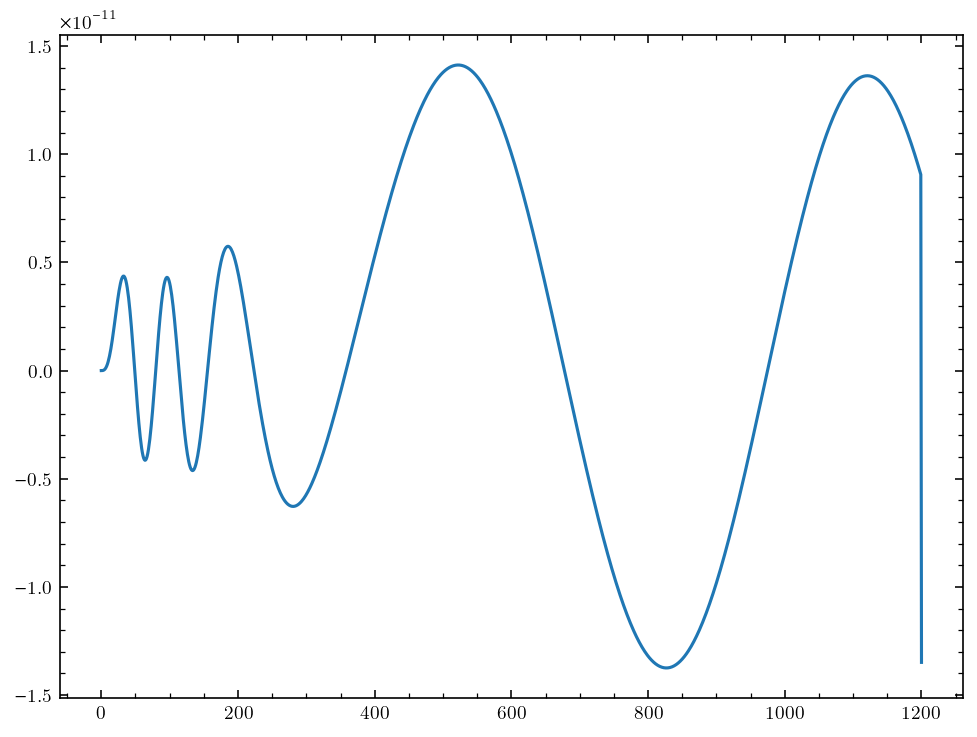

In [28]:
plt.plot(grom.emulate([lecs]) - grom.simulate([lecs]))

In [25]:
grom.simulate([lecs])

(3,)


array([[ 0.00000000e+00],
       [ 2.50482768e-08],
       [ 2.00431911e-07],
       [ 6.76714553e-07],
       [ 1.60491548e-06],
       [ 3.13673499e-06],
       [ 5.42477688e-06],
       [ 8.62276711e-06],
       [ 1.28857676e-05],
       [ 1.83703844e-05],
       ...,
       [-9.40381729e-02],
       [-9.30741922e-02],
       [-9.20993565e-02],
       [-9.11137787e-02],
       [-9.01175733e-02],
       [-8.91108558e-02],
       [-8.80937430e-02],
       [-8.70663530e-02],
       [-8.60288049e-02],
       [ 1.28076111e-01]])

In [362]:
grom.emulate([lecs], estimate_norm_residual=True, 
                calc_error_bounds=True, self_test=True)

sum of the emulator basis coeffs -2.721775153860711
[[1.92422662e-05 1.92422662e-05 1.92422662e-05]]
max_diff 7.241454072666464e-17


(array([[-1.52950718e-16],
        [ 1.34664976e-08],
        [ 1.07864171e-07],
        [ 3.64784452e-07],
        [ 8.67135814e-07],
        [ 1.69979354e-06],
        [ 2.95023906e-06],
        [ 4.70918540e-06],
        [ 7.07118554e-06],
        [ 1.01352203e-05],
        ...,
        [-9.28182928e-02],
        [-9.18668170e-02],
        [-9.09046270e-02],
        [-8.99318344e-02],
        [-8.89485519e-02],
        [-8.79548937e-02],
        [-8.69509751e-02],
        [-8.59369125e-02],
        [-8.49128237e-02],
        [ 1.26414684e-01]]),
 array([[1.92422662e-05, 1.92422662e-05, 1.92422662e-05]]),
 array([[2.69815989e-06, 7.24899366e-01]]))

## Data class for LECs

In [ ]:
class Theta:
    def __init__(self):
        pass

    def __post_init__(self):
        self.check()

In [77]:
tx1 = np.empty((3,4,5))
tx1[0, :, :] = 0
tx1[1, :, :] = 1
tx1[2, :, :] = 2

In [80]:
tx1.reshape((4,3*5))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]])

In [88]:
np.hstack(np.split(tx1, 3))

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.]]])

In [102]:
np.array(np.split(tx1, 3)).shape
np.squeeze(np.array(np.split(tx1, 3)))#shape

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]],

       [[2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.]]])

In [105]:
xx22 = np.column_stack(np.squeeze(np.split(tx1, 3)))

In [107]:
from scipy.linalg import orth
orth(np.column_stack((xx22,xx22)))

array([[-0.5],
       [-0.5],
       [-0.5],
       [-0.5]])